# About this notebook

In this notebook the ordinary kriging algorithm is used to predict the amount of lead in the soil of the riverbank Meuse in the Netherlands. This is one of the textbook examples in Spatial statistics. The performance of making predictions with kriging is benchmarked with a simple nearest neighbours model. Finally a map is made by predicting a grid. The map is plot as a heatmap on top on an interactive map.

In [1]:
# This example requires some extra packages compared to the PyKrige package. 
# At the time of the creation, I used the conda package manager
# and installed the following (with the versions at the time):
# pandas 0.18.1, geopandas 0.2.1, seaborn 0.7.1, folium 0.2.1, shapely 1.5.16
# If you use pip, "pip install geopandas folium seaborn" should work to.
import os
import requests
import zipfile
import geopandas as gpd
import shapely
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import folium
from folium import plugins
%matplotlib inline
from pykrige.ok import OrdinaryKriging
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import pykrige.kriging_tools as kt
import seaborn as sb
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

## Download and import the shapefile

- Download the zipfile from http://spatial-analyst.net/book/meusegrids
- Extract the zipfile
- Delete the zipfile

In [2]:
if(~os.path.isfile('meuse.zip')):
    url = 'http://spatial-analyst.net/book/system/files/meuse.zip'
    results = requests.get(url)
    print('Status code download: {}'.format(results.status_code))
with open('meuse.zip', 'wb') as f:
    f.write(results.content)
zip_ref = zipfile.ZipFile('meuse.zip', 'r')
zip_ref.extractall('meuse_example_data/')
zip_ref.close()
os.remove('meuse.zip')

Status code download: 200


In [3]:
meuse = gpd.read_file('meuse_example_data/meuse.shp')
meuse.crs = {'init':'epsg:28992'}
meuse['x'] = meuse['geometry'].apply(lambda x: x.x)
meuse['y'] = meuse['geometry'].apply(lambda x: x.y)
meuse.sample()

,cadmium,copper,dist,dist.m,elev,ffreq,geometry,landuse,lead,lime,om,soil,zinc,x,y
147,3.1,42.0,0.092144,120.0,7.706,3,POINT (178786 329822),Ah,258.0,0,8.4,1,783.0,178786.0,329822.0


## Spatial plot

In [4]:
feature_to_plot = 'lead'

meuse_lat_long = meuse.to_crs({'init': 'epsg:4326'})
meuse_lat_long['long'] = meuse_lat_long.geometry.apply(lambda x: x.x)
meuse_lat_long['lat'] = meuse_lat_long.geometry.apply(lambda x: x.y)
mean_long = np.mean(meuse_lat_long['long'])
mean_lat = np.mean(meuse_lat_long['lat'])
m = folium.Map([mean_lat, mean_long], zoom_start=13, tiles='Stamen Toner')
scale = folium.colormap.linear.YlOrRd.scale(vmin=0, vmax=meuse_lat_long[feature_to_plot].max())
for row in meuse_lat_long.iterrows():
    folium.CircleMarker(location=[row[1]['lat'], row[1]['long']], radius=50, color=None, fill_opacity=1,
                    fill_color=scale(row[1][feature_to_plot])).add_to(m)
m.add_children(scale)

## Split the data into test and train

Control the random split with setting a seed so the results are reproducable.

In [5]:
np.random.seed(0)
test_indexes = np.random.choice(a=meuse.index, size=int(np.round(len(meuse.index.values)/4)))
train_indexes = [index for index in meuse.index if index not in test_indexes]
meuse_test = meuse.loc[test_indexes,:].copy()
meuse_train = meuse.loc[train_indexes,:].copy()
print('Number of observations in training: {}, in test: {}'.format(len(meuse_train), len(meuse_test)))

Number of observations in training: 122, in test: 39


## Ordinary kriging

Variogram parameters are set with trail and error.

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Sill: 13500
Range: 900
Nugget: 4000 



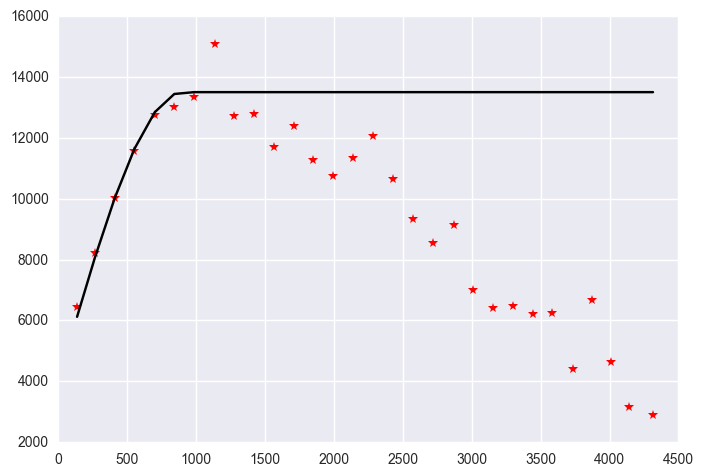

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Debugging:
Exact values: True
Model parameters: 4000
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Executing Ordinary Kriging...

Debugging:
Exact values: True
Model parameters: 4000
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [6]:
model = OrdinaryKriging(x=meuse_train['x'], y=meuse_train['y'], z=meuse_train['lead'], verbose=True,
                variogram_parameters=[13500, 900, 4000],
                enable_plotting=True, nlags=30, weight=True, variogram_model='spherical')
meuse_train['prediction'] = model.execute(style='points',xpoints=meuse_train['x'], ypoints=meuse_train['y'] )[0].data
meuse_train['kriging_residual'] = meuse_train['lead'] - meuse_train['prediction']
meuse_test['prediction'] = model.execute(style='points', xpoints=meuse_test['x'], ypoints=meuse_test['y'] )[0].data
meuse_test['kriging_residual'] = meuse_test['lead'] - meuse_test['prediction']

## Model performance

- Performance on training data (kriging is an exact interpollator, so perfect prediction)
- Performance on test data

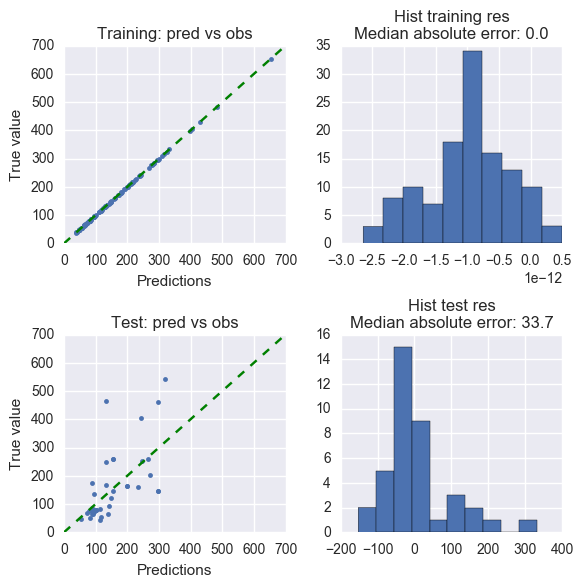

In [7]:
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.plot(meuse_train['prediction'], meuse_train['lead'], '.')
plt.title('Training: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.plot([0,700], [0,700], 'g--')
plt.ylim(0,700)
plt.xlim(0,700)
plt.subplot(222)
meuse_train['kriging_residual'].hist()
plt.title('Hist training res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(meuse_train['kriging_residual']))))
plt.subplot(223)
plt.plot(meuse_test['prediction'], meuse_test['lead'], '.')
plt.plot([0,700], [0,700], 'g--')
plt.title('Test: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.ylim(0,700)
plt.xlim(0,700)
plt.subplot(224)
meuse_test['kriging_residual'].hist()
plt.title('Hist test res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(meuse_test['kriging_residual']))))
plt.tight_layout()

## Benchmark with Nearest Neighbours regression

Optimise number of neighbours with sklearn gridsearch

In [8]:
parameters = {'n_neighbors':np.arange(1,10)}
nn_model = KNeighborsRegressor()
nn_model_cv = GridSearchCV(nn_model, parameters)
nn_model_cv = nn_model_cv.fit(meuse_train[['x', 'y']], meuse_train['lead']) 
print('Optimal number of neighbours {}'.format(nn_model_cv.best_params_))
nn_model = nn_model_cv.best_estimator_
meuse_test['nn_prediction'] = nn_model.predict(meuse_test[['x', 'y']])
meuse_test['nn_residual'] = meuse_test['lead'] - meuse_test['nn_prediction']

Optimal number of neighbours {'n_neighbors': 4}


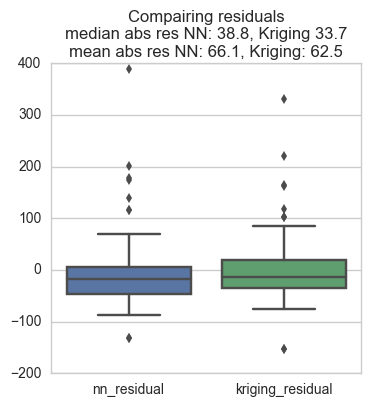

In [9]:
sb.set_style("whitegrid")
plt.figure(figsize=(4,4))
sb.boxplot(data=meuse_test[["nn_residual","kriging_residual"]] )
plt.title('Compairing residuals\nmedian abs res NN: {:.1f}, Kriging {:.1f}\nmean abs res NN: {:.1f}, Kriging: {:.1f}'\
          .format(np.median(np.abs(meuse_test['nn_residual'])), np.median(np.abs(meuse_test['kriging_residual'])),
                 np.mean(np.abs(meuse_test['nn_residual'])), np.mean(np.abs(meuse_test['kriging_residual']))))

## Help functions to sample a grid from a polygon

As found on http://portolan.leaffan.net/creating-sample-points-with-ogr-and-shapely-pt-2-regular-grid-sampling/

In [10]:
class PolygonPointSampler(object):
 
    def __init__(self, polygon=''):
        u"""
        Initialize a new PolygonPointSampler object using the specified polygon
        object (as allocated by Shapely). If no polygon is given a new empty
        one is created and set as the base polygon.
        """
        if polygon:
            self.polygon = polygon
        else:
            self.polygon = Polygon()
        self.samples = list()
        self.sample_count = 0
        self.prepared = False
 
    def add_polygon(self, polygon):
        u"""
        Add another polygon entity to the base polygon by geometrically unifying
        it with the current one.
        """
        self.polygon = self.polygon.union(polygon)
        self.prepared = False
    
    def get_spatial_df(self):
        geo_df = pd.DataFrame(self.samples, columns=['geometry']).set_geometry('geometry')
        geo_df['x'] = geo_df['geometry'].apply(lambda x: x.coords[0][0])
        geo_df['y'] = geo_df['geometry'].apply(lambda x: x.coords[0][1])
        return geo_df
 
    def print_samples(self):
        u"""
        Print all sample points using their WKT representation.
        """
        for sample_pt in self.samples:
            print(sample_pt)
 
    def prepare_sampling(self):
        u"""
        Prepare the actual sampling procedure by splitting up the specified base
        polygon (that may consist of multiple simple polygons) and appending its
        compartments to a dedicated list.
        """
        self.src = list()
        if hasattr(self.polygon, 'geoms'):
            for py in self.polygon:
                self.src.append(py)
        else:
            self.src.append(self.polygon)
        self.prepared = True
 
    def perform_sampling(self):
        u"""
        Create a stub for the actual sampling procedure.
        """
        raise NotImplementedError
    
class RegularGridSampler(PolygonPointSampler):
    def __init__(self, polygon = '', x_interval = 100, y_interval = 100):
        super(self.__class__, self).__init__(polygon)
        self.x_interval = x_interval
        self.y_interval = y_interval
    
    def perform_sampling(self):
        u"""
        Perform sampling by substituting the polygon with a regular grid of
        sample points within it. The distance between the sample points is
        given by x_interval and y_interval.
        """
        if not self.prepared:
            self.prepare_sampling()
        ll = self.polygon.bounds[:2]
        ur = self.polygon.bounds[2:]
        low_x = int(ll[0]) / self.x_interval * self.x_interval
        upp_x = int(ur[0]) / self.x_interval * self.x_interval + self.x_interval
        low_y = int(ll[1]) / self.y_interval * self.y_interval
        upp_y = int(ur[1]) / self.y_interval * self.y_interval + self.y_interval
        
        for x in floatrange(low_x, upp_x, self.x_interval):
            for y in floatrange(low_y, upp_y, self.y_interval):
                p = shapely.geometry.Point(x, y)
                if p.within(self.polygon):
                    self.samples.append(p)

def floatrange(start, stop, step):
    while start < stop:
        yield start
        start += step


## Sample a grid 

- Find the convex hull surrounding the measurements
- Sample a grid as found with the help functions

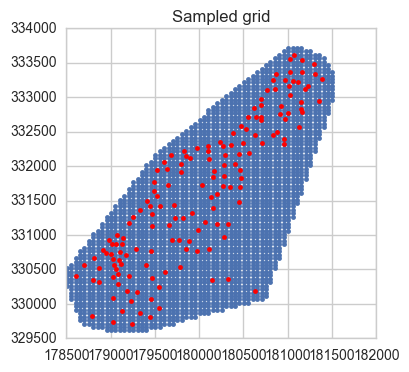

In [11]:
convex_hull = shapely.geometry.MultiPoint(list(meuse.geometry)).convex_hull.buffer(150)
sampler = RegularGridSampler(convex_hull, x_interval=50, y_interval=50)
sampler.perform_sampling()
grid_points = sampler.get_spatial_df()
plt.figure(figsize=(4,4))
plt.plot(grid_points['x'], grid_points['y'], '.')
plt.plot(meuse['x'], meuse['y'], 'r.')
plt.title('Sampled grid')

## Krige a value for each grid point

In [12]:
grid_points['prediction'] = model.execute(style='points', xpoints=grid_points['x'], ypoints=grid_points['y'])[0].data

Executing Ordinary Kriging...

Debugging:
Exact values: True
Model parameters: 4000
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


## Transform data for a map

- Transform to lat long projection
- From long to wide format
- Fill in missing values

In [13]:
grid_points_gpd = grid_points.set_geometry('geometry')
grid_points_gpd.crs = {'init':'epsg:28992'}
grid_points_gpd = grid_points_gpd.to_crs({'init': 'epsg:4326'})
grid_points_gpd['long'] = grid_points_gpd.geometry.apply(lambda x: x.x)
grid_points_gpd['lat'] = grid_points_gpd.geometry.apply(lambda x: x.y)

In [14]:
grid_points_pivot = grid_points_gpd.pivot(values='prediction', columns='x', index='y').fillna(0)
grid_points_pivot = grid_points_pivot.loc[:,grid_points_pivot.columns.sort_values(ascending=True)]
grid_points_pivot = grid_points_pivot.loc[grid_points_pivot.index.sort_values(ascending=True),:]

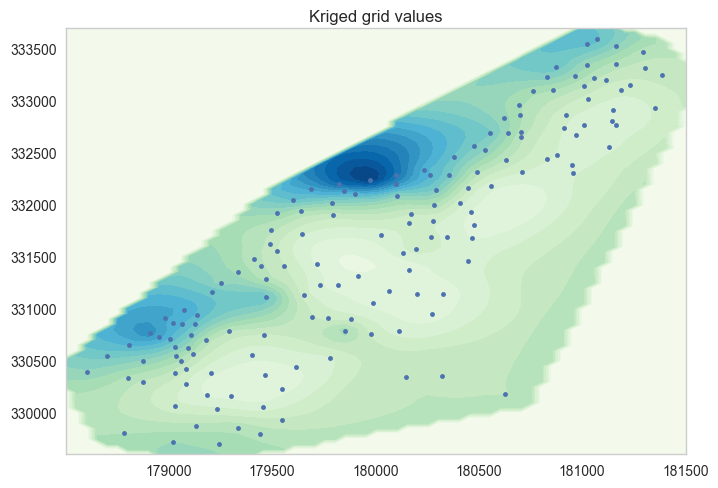

In [15]:
plt.contourf(np.unique(grid_points_pivot.columns.values), np.unique(grid_points_pivot.index.values), 
             grid_points_pivot.values/np.nanmax(grid_points_pivot.values),20,cmap='GnBu')
plt.plot(meuse['x'], meuse['y'], '.')
plt.title('Kriged grid values')

## Folium plot

In [16]:
def color_function(value):
    if (value==0) | (value==np.nan) : return (0,0,0,0)
    else: 
        color = matplotlib.cm.YlOrRd(value) 
        return color

In [17]:
m = folium.Map([mean_lat, mean_long], zoom_start=13, tiles='Stamen Toner')
m.add_children(plugins.ImageOverlay(image = (grid_points_pivot.values/np.nanmax(grid_points_pivot.values)), 
                                           opacity=0.7,origin='lower',
                                           colormap=color_function,
                                   bounds = [[np.min(grid_points_gpd['lat']), np.min(grid_points_gpd['long'])],
                                            [np.max(grid_points_gpd['lat']), np.max(grid_points_gpd['long'])]]))
for row in meuse_lat_long.iterrows():
    folium.CircleMarker(location=[row[1]['lat'], row[1]['long']], radius=50, color=None, fill_opacity=1,
                    fill_color=scale(row[1][feature_to_plot])).add_to(m)
m.add_children(scale)